In [15]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

In [16]:
def sigmoid(x):
    if x < 0:
        return np.exp(x)/(1+np.exp(x))
    else:
        return 1/(1+np.exp(-x))
vsigmoid = np.vectorize(sigmoid)   

In [17]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [88]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data[data.columns[0]]))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data[test_data.columns[0]])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)


x_train = train_data_std
y_train = np.where(y_train == 0,  1, -1)
x_test = test_data_std
y_test = np.where(y_test == 0,  1, -1)

In [19]:
def neural_net(x,w,c):
    #shape of x: (n,d)
    #shape of w: (N,d)
    #shape of c: (1, N)
    n = x.shape[0]
    d = x.shape[1]
    N = w.shape[0]
    return (1/N*c@vsigmoid(w@x.T)).reshape(1,n)

In [33]:
def train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-2):
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #sgd - update weights (using KL loss)
    count = 1
    
    for x,y in tqdm(zip(x_train,y_train)):
        y = y.reshape(1,-1)
        x = x.reshape(1,-1)
        f = neural_net(x,w,c).reshape(1,-1)
        dw = 1/N * ((f-y)@c).T*(vsigmoid(w@x.T)*(1-vsigmoid(w@x.T)))*x
        dc = 1/N * (f-y).T*vsigmoid(w@x.T).reshape(1,-1)
        w -= learning_rate*dw
        c -= learning_rate*dc
        if count in [1, 10 , 100] or count in (10**np.linspace(3, 5.7, 20)).astype(int): 
            f_test = neural_net(x_test,w,c).reshape(-1,1)
            y_test = y_test.reshape(-1,1)
            loss = 0.5*np.mean((f_test-y_test)**2)
            print('Epoch count: {}, Loss: {}'.format(count, loss))
            losses.append(loss)
        count += 1 
        
    return c, w, np.ndarray.flatten(c), losses

In [ ]:
c, w, params, losses = train(x_train, y_train, x_test, y_test, N = 1000, learning_rate = 2e2)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 29370.505348552066
Epoch count: 10, Loss: 8834.687189826118
Epoch count: 100, Loss: 99.3720414047287
Epoch count: 1000, Loss: 9.76727330853363
Epoch count: 1387, Loss: 11.462618187845658
Epoch count: 1924, Loss: 7.3530394115926025
Epoch count: 2668, Loss: 4.7992220951566384


In [ ]:
plt.hist(params, label = 'N: 200', bins = 20)
plt.legend()

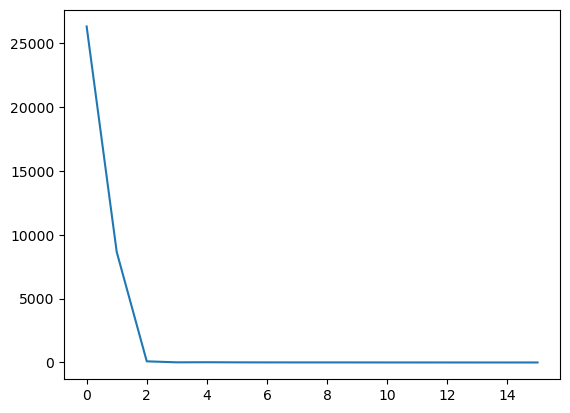

In [104]:
plt.plot(losses)

In [101]:
neural_net(x_test[23].reshape(1,-1), w,c)

array([[-1.3551159]])

In [37]:
w.shape

(100, 784)

In [69]:
y_test[24]

1

In [66]:
np.where(y_test == 1)

(array([   2,    9,   12,   24,   27,   54,   68,   70,  100,  125,  135,
         147,  156,  182,  187,  191,  193,  214,  245,  268,  270,  293,
         295,  296,  304,  310,  311,  323,  326,  345,  364,  371,  379,
         406,  423,  439,  440,  442,  458,  484,  489,  497,  524,  544,
         545,  551,  560,  563,  566,  580,  585,  591,  596,  607,  610,
         619,  641,  643,  655,  660,  700,  703,  712,  716,  720,  722,
         741,  749,  762,  793,  803,  820,  844,  850,  853,  870,  883,
         894,  895,  903,  931,  971,  980,  992,  996, 1000, 1008, 1033,
        1046, 1060, 1083, 1093, 1120, 1147, 1153, 1175, 1187, 1190, 1194,
        1196, 1202, 1217, 1219, 1222, 1230, 1245, 1260, 1270, 1272, 1287,
        1293, 1296, 1332, 1378, 1389, 1398, 1403, 1407, 1410, 1415, 1437,
        1444, 1453, 1456, 1467, 1486, 1503, 1516, 1525, 1532, 1533, 1534,
        1557, 1564, 1569, 1588, 1589, 1609, 1618, 1620, 1622, 1637, 1649,
        1691, 1699, 1707, 1711, 1712, 